# DS 100 Final Project: A Basketball Analysis

## Given 2 teams' average statistics before a game, how well can we predict who wins?

### Creators: Alec Zhou, Prashant Malyala

## I. This Project

[Insert description of project here]

## II. Set Up

Below, we will import the necessary libraries for our data analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import date

Now, we'll read in the relevant basketball data.

In [2]:
#from the provided ds100 dataset
team_box_score = pd.read_csv('basketball/Basketball-TeamBoxScores.csv')
standings = pd.read_csv('basketball/Standings.csv')

## III. Data Preview

Let's briefly see what our data looks like.

### i. Standings Data:

The granularity of this data is quite fine; it seems that the Standings table has a record representing each team's standing at every date of the season (after the games on that date occur). The columns are rollups and seem to represent aggregate statistics (such as total points scored, current streak, etc.) through each date for each team.

In [3]:
standings.head(5)

,stDate,teamAbbr,rank,rankOrd,gameWon,gameLost,stk,stkType,stkTot,gameBack,...,rel%Indx,mov,srs,pw%,pyth%13.91,wpyth13.91,lpyth13.91,pyth%16.5,wpyth16.5,lpyth16.5
0,2012-10-30,ATL,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
1,2012-10-30,BKN,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
2,2012-10-30,BOS,14,14th,0,1,L1,loss,1,1.0,...,0.0,-13.0,-13.0,0.072,0.1687,13.8334,68.1666,0.131,10.742,71.258
3,2012-10-30,CHA,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
4,2012-10-30,CHI,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000


In [4]:
#all 30 teams are listed on this date even though not all of them played; must be a full date by date record
len(standings[standings['stDate'] == '2012-10-30'])

30

### ii. Team Box Score Data:

The granularity of the team box score data is also rather fine; it seems that this table has a record for each game of each season. The column statistics provided match the granularity of each record, as these statistics are generally measured or computed using only data from that game.

In [5]:
team_box_score.head(5)

,gmDate,gmTime,seasTyp,offLNm1,offFNm1,offLNm2,offFNm2,offLNm3,offFNm3,teamAbbr,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,WAS,...,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
1,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,CLE,...,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
2,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,BOS,...,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832
3,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,MIA,...,62.7083,112.6515,126.3381,-13.6866,0.4643,18.8501,1.5000,25.0000,94.9832,94.9832
4,2012-10-30,22:30,Regular,Foster,Scott,Zielinski,Gary,Dalen,Eric,DAL,...,58.6458,99.3678,108.1034,-8.7356,0.5000,18.6567,1.7143,42.8571,91.5790,91.5790


Note that for each set of 3 officials, there are 2 games listed on each date. This led us to suspect that the Team Box Score data had two entries per game, one for each team. We can verify this in the cell below.

In [6]:
#shows that each game is listed twice, once for each team
team_box_score[team_box_score['gmDate'] == '2012-10-30'][['teamAbbr', 'opptAbbr']]

,teamAbbr,opptAbbr
0,WAS,CLE
1,CLE,WAS
2,BOS,MIA
3,MIA,BOS
4,DAL,LAL
5,LAL,DAL


So not only do we have all the team and opposing team's statistics per game entry, we have two listings of every game! Certainly there's some redundancy in this data, and this is going to be an important point we will revisit when building our model.

Finally, let's see how complete this data is. There are 30 teams in the league, 82 games per season, and this data covers the 2012-2013 through 2017-2018 seasons (6 seasons). So we would expect this many records:

In [7]:
30 * 82 * 6

14760

Let's see what percentage of records we actually have.

In [8]:
team_box_score.shape[0] / 14760 * 100

99.98644986449865

While not as perfect as we may have expected, it seems that the vast majority of the data is present. Since the effects of missing just a couple of records won't greatly affect our analysis, we will continue forward.

## IV: Data Cleaning

Right now, both our tables have a lot of columns, making them quite difficult to read or interpret. In this section, we will use domain expertise to compute more useful statistics and to replace or drop some columns.

### i. Cleaning up the Standings Data

Let's look at the standings data again.

In [9]:
standings.head()

,stDate,teamAbbr,rank,rankOrd,gameWon,gameLost,stk,stkType,stkTot,gameBack,...,rel%Indx,mov,srs,pw%,pyth%13.91,wpyth13.91,lpyth13.91,pyth%16.5,wpyth16.5,lpyth16.5
0,2012-10-30,ATL,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
1,2012-10-30,BKN,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
2,2012-10-30,BOS,14,14th,0,1,L1,loss,1,1.0,...,0.0,-13.0,-13.0,0.072,0.1687,13.8334,68.1666,0.131,10.742,71.258
3,2012-10-30,CHA,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
4,2012-10-30,CHI,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000


**Dropping certain columns:**

Rank, or seed, is determined by a variety of factors, including record (wins vs losses) and performance in a team's division. We believe that because our goal is not to predict standing but rather a win or a loss for a given game, rank isn't as effective a measure as winning percentage for our analysis. Also, because of the method by which we will split dataframes and use indices in section **V. Data Transformations**, we actually won't need the gamePlay column either.

We also believe that information like totals for ptsFor and ptsAgnst aren't as useful as averages (ptsScore, ptsAllow). Opponent statistics like opptGmPlay and opptGmWon are effectively summarized in the strength of schedule (sos) column. Finally, statistics like rel%Indx and Pythagorean statistics are difficult to interpret; the goal of our analysis is to determine more simple statistics that have important relationships with a team's likelihood of winning. Consequently, we will drop all of these columns below.

In [10]:
standings = standings.drop(['rank', 'rankOrd', 'gameBack', 'gamePlay', 'ptsFor', 'ptsAgnst', 'opptGmPlay',
                            'opptGmWon', 'opptOpptGmPlay', 'opptOpptGmWon', 'rel%Indx', 'pyth%13.91', 'wpyth13.91',
                           'lpyth13.91', 'pyth%16.5', 'wpyth16.5', 'lpyth16.5'], axis=1)

**Winning percentages:**

There's still a lot of data that could be summarized more easily using numbers and percentages. Let's start with winning percentages.

The Standings table currently has columns for gameWon, gameLost, homeWin, homeLoss, awayWin, awayLoss, confWin, and confLoss. Let's convert all these numbers into more concise percentages, like total winning percentage, home winning percentage, etc.

In [11]:
# total winning percentage is (wins) / (wins + losses)
standings['total_wpc'] = np.divide(standings['gameWon'], standings['gameWon'] + standings['gameLost'])
# wherever there were 0 games played, we divided by 0 (NaN). replace these
standings = standings.fillna(0)
# can now drop gameWon, gameLost, as this information is summarized by our wpc statistic
standings = standings.drop(['gameWon', 'gameLost'], axis=1)

# follow the same process as above for home_wpc, away_wpc, and conf_wpc
standings['home_wpc'] = np.divide(standings['homeWin'], standings['homeWin'] + standings['homeLoss'])
standings['away_wpc'] = np.divide(standings['awayWin'], standings['awayWin'] + standings['awayLoss'])
standings['conf_wpc'] = np.divide(standings['confWin'], standings['confWin'] + standings['confLoss'])
standings = standings.fillna(0)
standings = standings.drop(['homeWin', 'homeLoss', 'awayWin', 'awayLoss', 'confWin', 'confLoss'], axis=1)

**Streaks:**

Data regarding whether or not a team is on a streak could be quite useful. Right now, this information is encapsulated in strings, but what if we were to represent them more interpretably using numbers?

One way we might do this is by representing losing streaks with negative numbers and winning streaks with positive ones. The length of the streak would be the absolute value of the number.

In [12]:
# function that converts streak strings into numbers
def stk_to_num(x):
    if x == '-':
        return 0
    elif x[0] == 'L':
        return -1 * int(x[1:])
    else:
        return int(x[1:])

In [13]:
# once we have numerically represented the streaks, there's no point keeping the string data
standings['streak'] = standings['stk'].apply(stk_to_num)
standings = standings.drop(['stk', 'stkType', 'stkTot'], axis=1)

**Last Five/Last Ten:**

Finally, we have this information about how many games each team won in their last 5 and last 10 games. Let's represent these as percentages as well.

In [14]:
standings['lastTen_wpc'] = standings['lastTen'] / 10
standings['lastFive_wpc'] = standings['lastFive'] / 5

In [15]:
standings = standings.drop(['lastFive', 'lastTen'], axis=1)

### ii. Cleaning up the Team Box Score Data

Now let's take another look at the Team Box Score data.

In [16]:
team_box_score.head()

,gmDate,gmTime,seasTyp,offLNm1,offFNm1,offLNm2,offFNm2,offLNm3,offFNm3,teamAbbr,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,WAS,...,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
1,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,CLE,...,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
2,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,BOS,...,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832
3,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,MIA,...,62.7083,112.6515,126.3381,-13.6866,0.4643,18.8501,1.5000,25.0000,94.9832,94.9832
4,2012-10-30,22:30,Regular,Foster,Scott,Zielinski,Gary,Dalen,Eric,DAL,...,58.6458,99.3678,108.1034,-8.7356,0.5000,18.6567,1.7143,42.8571,91.5790,91.5790


**Dropping certain columns:**

In general, we believe like factors like gmTime and the identity of the officials are relatively negligible in determining the outcome of a game. seasTyp is also not very informative, as all of these games seem to have taken place during the regular season.

In [17]:
# shows that all games took place during the regular season
team_box_score['seasTyp'].unique()

array(['Regular'], dtype=object)

In [18]:
# dropping these columns
team_box_score = team_box_score.drop(['gmTime', 'seasTyp', 'offLNm1', 'offFNm1', 'offLNm2', 'offFNm2',
                                      'offLNm3', 'offFNm3'], axis=1)

We will also need to drop the possession and pace columns. As we can see from looking at the head of the data above, these statistics are game specific and the same for both teams in a game, meaning they wouldn't make a lot of sense to average for any team. The good thing is we already have stats like offensive rating and defensive rating which are computed using the possession of each game and make more sense to average over the course of a season.

In [19]:
# dropping these columns
team_box_score = team_box_score.drop(['poss', 'pace'], axis=1)

**Representing wins:**

When it comes time to train and test our model, we will want our results to be easily interpretable. Rather than using strings for 'Win' and 'Loss' in the teamRslt column, let's convert this to a binary indicator, where 0's represent losses and 1's represent wins.

In [20]:
#make the result column a binary indicator
team_box_score = team_box_score.replace(to_replace=['Loss', 'Win'], value=[0, 1])
#verify that we only have 0's and 1's in this column
team_box_score['teamRslt'].unique()

array([0, 1])

## V: Data Transformations

**Section i:**

Right now, our standings data has aggregate statistics for each team through a certain date and our team box score data has the game stats for each date. Both tables also have date attributes, so if we were to combine them, we could try and make use of the statistics offered by both. Thus, the first part of this section will be merging the two tables together.

**Section ii:**

The second section will be focused on how we can transform our data to represent real world circumstances. In reality, we will never have the team box score data of a game before said game (otherwise, predicting a win is as easy as seeing who scored more points). So instead, what we will do is try to make the team box score data look more like the standings data (i.e. we will calculate the team's and oppt's average points, average assists, average STL/TO ratios, etc. for every game of the season).

Throughout the process we will need to be mindful of the way we take averages. We want our averages to represent statistics we would have BEFORE game *i* happened, so we would need to take the average of only games *0...i-1*. As for the standings data, because this data has been aggregated after the games that occured that day, we would simply need to move this data one game down for each team. We will walk through each step of this process in section ii. through code commenting and markdown cells, so please refer to those for a more detailed walk through.

We will be using the following function throughout this section to extract data for each particular season.

In [21]:
def get_nth_season(data, n):
    #1st season begins in 2012 and 6th season begins in 2017
    return data[(data['gmDate'] > date(2011 + n, 10, 1)) & (data['gmDate'] < date(2012 + n, 5, 1))]

### i. Merging Standings, Team Box Score Data

We will want to merge each team's games in the team box score data with what their standing was on that same date. Consequently, we will need to merge on both date and teamAbbr.

In [22]:
# inner join the tables on the date and teamAbbr
# now we'll have each team's stats for that game and their stats up till that date in the season
team_box_score = pd.merge(team_box_score, standings, how='inner',
                          left_on=['gmDate', 'teamAbbr'], right_on=['stDate', 'teamAbbr'])

#drop the added stDate column, which is redundant as we already have a gmDate column
team_box_score = team_box_score.drop('stDate', axis=1)

Now, we'll make our gmDate column into a datetime object for future use.

In [23]:
#finally, convert gmDate into a datetime type for ease of manipulation
team_box_score['gmDate'] = team_box_score['gmDate'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())

In [24]:
team_box_score.head()

,gmDate,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,teamMin,teamDayOff,teamPTS,teamAST,...,mov,srs,pw%,total_wpc,home_wpc,away_wpc,conf_wpc,streak,lastTen_wpc,lastFive_wpc
0,2012-10-30,WAS,East,Southeast,Away,0,240,0,84,26,...,-10.0,-10.0,0.1707,0.0,0.0,0.0,0.0,-1,0.0,0.0
1,2012-10-30,CLE,East,Central,Home,1,240,0,94,22,...,10.0,10.0,0.8293,1.0,1.0,0.0,1.0,1,0.1,0.2
2,2012-10-30,BOS,East,Atlantic,Away,0,240,0,107,24,...,-13.0,-13.0,0.0720,0.0,0.0,0.0,0.0,-1,0.0,0.0
3,2012-10-30,MIA,East,Southeast,Home,1,240,0,120,25,...,13.0,13.0,0.9280,1.0,1.0,0.0,1.0,1,0.1,0.2
4,2012-10-30,DAL,West,Southwest,Away,1,240,0,99,22,...,8.0,8.0,0.7634,1.0,0.0,1.0,1.0,1,0.1,0.2


### ii. Computing Averages

**Getting each season's data:**

The first thing we will need to do is split our team box score data by season. We will do so below using our *get_nth_season* function from the beginning of the section.

In [25]:
# data for each season
all_seasons = []
for i in range(1, 7):
    # compile every season's data into one list
    all_seasons.append(get_nth_season(team_box_score, i))

**Key functions:**

Now, we will need to split each season up by team in order to compute each team's average statistics. We will use the following functions each time in order to do this. The components of these functions end up being quite long, so we've included a variety of comments to break them down.

In [26]:
def all_team_data(season_data, which_team):
    """
    This function takes the data for one season and compiles a list of 30 DataFrames; each DataFrame in the list
    represents the season data for one team in the NBA.
    
    Based on the argument given to which_team, this function will either group by the teamAbbr or the opptAbbr.
    The purpose of this is we will need to group by the former to compute the provided team's average stats before
    every game, but we will later need to group by the latter to compute the opponent's average stats before
    every game.
    """
    if which_team == 0:
        teams = season_data['teamAbbr'].unique()
        grouped = season_data.groupby('teamAbbr')
    else:
        teams = season_data['opptAbbr'].unique()
        grouped = season_data.groupby('opptAbbr')
    teams_data = []
    for team in teams:
        teams_data.append(grouped.get_group(team))
    return teams_data

In [27]:
def compute_averages(team, columns):
    """
    This function takes the season data for one team in the NBA and a list of columns. For every column c,
    this function replaces every entry, i_c, in the column with the average of its previous entries
    mean(0_c, ..., (i-1)_c).
    
    In other words, say I pass in the 2012-2013 season data for the Washington Wizards and the following
    list of columns: ['teamPTS', 'teamAST']. For every game in the season data, I will replace the teamPTS
    and teamAST recorded for that game with the Wizards' average teamPTS and teamAST during all games
    BEFORE that one. Essentially, it will be like the Wizards' 50th game was tomorrow and I had their season
    statistical averages up until that point in time. The point of this transformation is to pretend that
    we are analysts looking at stats before a game happens trying to determine who will win using a model.
    
    This function goes through the entries in reverse order, so entries are only
    replaced after all computation involving them has been completed.
    """
    # first reset the index so that all games are numbered 0-81
    team = team.reset_index()
    team = team.drop('index', axis=1)
    
    # replace the final entry in each column with the average of the prev n-1 entries
    for col in columns:
        team.loc[len(team)-1, col] = team.loc[0:(len(team)-2)][col].mean()
    
    # for each entry, i, in each column, replace that entry with the average of the previous i-1 entries
    for i in range(len(team)-2):
        ind = len(team) - i - 2
        for col in columns:
            # for each game, g, compute the team's total, say, pts after game g. then subtract the points scored in game g
            # and divide by the number of games that happened before game g. this yields the team's avg pts before game g.
            team.loc[ind,col] = (team.loc[ind+1,col]*(ind+1)-team.loc[ind,col])/(ind)

    # set all stats before the first game to 0
    for col in columns:
        team.loc[0,col] = 0
    # return the dataframe
    return team

In [28]:
def adjust_standings(team, columns):
    """
    This function essentially shifts all the standings data that we've added one entry down. This way, the data
    we'll use to predict won't include statistics from that game. Then we'll set all standings data for first
    games to 0.
    
    Call this function after calling compute_averages to ensure indices are numbered as desired.
    """
    # for each column we want to shift...
    for col in columns:
        # let entry n take the value of entry n-1
        for i in range(1, len(team)):
            ind = len(team) - i
            team.loc[ind, col] = team.loc[ind-1, col]
        # set entry 0 of each col to 0
        team.loc[0, col] = 0
    return team

**Calling the functions to compute our results:**

Note that in order to use the *compute_averages* and *adjust_standings* functions, we will need to pass in a list of labels corresponding to the columns we want to manipulate.

We will need to run *compute_averages* several times on 2 main occasions:
1. In the first occasion, we will have grouped by the teamAbbr and will be aiming to compute the average stats for the columns corresponding to that teamAbbr.
2. In the second occasion, we will have grouped by the opptAbbr and will be aiming to compute the average stats for the columns corresponding to that opptAbbr.

Consequently, we will need to make a *team_cols* list and an *oppt_cols* list, one for each occasion.

We will also need to make a list of *standings_cols*. This list will include the labels of all standing columns that we will need to shift using the *adjust_standings* function.

In [29]:
# team cols will be the columns we will aggregate grouping by teamAbbr
team_cols = ['teamMin', 'teamPTS', 'teamAST', 'teamTO', 'teamSTL', 'teamBLK', 'teamPF', 'teamFGA',
               'teamFGM', 'teamFG%', 'team2PA', 'team2PM', 'team2P%', 'team3PA', 'team3PM', 'team3P%', 'teamFTA',
               'teamFTM', 'teamFT%', 'teamORB', 'teamDRB', 'teamTRB', 'teamPTS1', 'teamPTS2', 'teamPTS3', 'teamPTS4',
               'teamPTS5', 'teamPTS6', 'teamPTS7', 'teamPTS8', 'teamTREB%', 'teamASST%', 'teamTS%', 'teamEFG%',
               'teamOREB%', 'teamDREB%', 'teamTO%', 'teamSTL%', 'teamBLK%', 'teamBLKR', 'teamPPS', 'teamFIC',
               'teamFIC40', 'teamOrtg', 'teamDrtg', 'teamEDiff', 'teamPlay%', 'teamAR', 'teamAST/TO', 'teamSTL/TO']
# oppt cols will be the columns we will aggregate grouping by opptAbbr
oppt_cols = ['opptMin', 'opptPTS', 'opptAST', 'opptTO', 'opptSTL', 'opptBLK', 'opptPF',
            'opptFGA', 'opptFGM', 'opptFG%', 'oppt2PA', 'oppt2PM', 'oppt2P%', 'oppt3PA', 'oppt3PM', 'oppt3P%',
            'opptFTA', 'opptFTM', 'opptFT%', 'opptORB', 'opptDRB', 'opptTRB', 'opptPTS1', 'opptPTS2', 'opptPTS3',
            'opptPTS4', 'opptPTS5', 'opptPTS6', 'opptPTS7', 'opptPTS8', 'opptTREB%', 'opptASST%', 'opptTS%',
            'opptEFG%', 'opptOREB%', 'opptDREB%', 'opptTO%', 'opptSTL%', 'opptBLK%', 'opptBLKR', 'opptPPS',
            'opptFIC', 'opptFIC40', 'opptOrtg', 'opptDrtg', 'opptEDiff', 'opptPlay%', 'opptAR', 'opptAST/TO',
            'opptSTL/TO']
# standing cols will be the columns we will need to shift
standing_cols = ['ptsScore', 'ptsAllow', 'ptsDiff', 'sos', 'mov', 'srs', 'pw%', 'total_wpc', 'home_wpc', 'away_wpc',
                'conf_wpc', 'streak', 'lastTen_wpc', 'lastFive_wpc']

In [30]:
#all_seasons[0].columns[57:]
#all_seasons[0].columns[0:15]

checked the below calculations against season records; everything checked out

In [31]:
# for every season...
for i in range(len(all_seasons)):
    # get the data for every team from that season
    list_of_teams = all_team_data(all_seasons[i], which_team=0)
    
    # for each team, compute averages for various columns
    # (see the compute_averages comments for details)
    for k in range(len(list_of_teams)):
        list_of_teams[k] = compute_averages(list_of_teams[k], team_cols)
        # also for each team, move all their standings data one entry down
        # for ex. we want the Wizards' streak number BEFORE game i, not after it.
        list_of_teams[k] = adjust_standings(list_of_teams[k], standing_cols)
    

    # once every team's averages have been computed, join them back into one season
    season_df = pd.concat(list_of_teams)
    
    # then sort the season by game date and assign it back into all_seasons
    season_df = season_df.sort_values(by='gmDate')
    all_seasons[i] = season_df

deal with oppt stats

In [32]:
all_seasons[0].tail(10)

,gmDate,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,teamMin,teamDayOff,teamPTS,teamAST,...,mov,srs,pw%,total_wpc,home_wpc,away_wpc,conf_wpc,streak,lastTen_wpc,lastFive_wpc
81,2013-04-17,LAC,West,Pacific,Away,1,240.617284,1,100.950617,23.864198,...,6.4815,5.9790,0.7134,0.679012,0.780488,0.575000,0.666667,6,0.7,1.0
81,2013-04-17,MIA,East,Southeast,Home,1,242.469136,2,102.851852,22.950617,...,7.8148,7.3273,0.7573,0.802469,0.900000,0.707317,0.784314,7,0.9,1.0
81,2013-04-17,CHI,East,Central,Home,1,241.851852,2,93.160494,22.962963,...,0.2840,-0.2119,0.5094,0.543210,0.575000,0.512195,0.647059,1,0.5,0.4
81,2013-04-17,DEN,West,Northwest,Home,1,242.777778,2,106.000000,24.370370,...,4.9012,4.3929,0.6614,0.691358,0.925000,0.463415,0.725490,2,0.7,0.8
80,2013-04-17,IND,East,Central,Home,0,241.875000,1,94.737500,20.350000,...,4.2000,3.7111,0.6383,0.612500,0.750000,0.475000,0.620000,-2,0.6,0.2
81,2013-04-17,HOU,West,Southwest,Away,0,240.925926,2,106.086420,23.209877,...,3.5679,3.0627,0.6175,0.555556,0.707317,0.400000,0.470588,-1,0.6,0.4
81,2013-04-17,OKC,West,Northwest,Home,0,241.851852,2,105.925926,21.444444,...,9.3951,8.8929,0.8094,0.740741,0.850000,0.634146,0.750000,4,0.8,0.8
80,2013-04-17,BOS,East,Atlantic,Away,0,245.000000,1,96.600000,22.800000,...,0.0750,-0.4192,0.5025,0.512500,0.675000,0.350000,0.540000,1,0.5,0.4
81,2013-04-17,LAL,West,Pacific,Home,1,240.617284,3,102.246914,22.111111,...,1.1235,0.6188,0.5370,0.543210,0.700000,0.390244,0.529412,4,0.8,0.8
81,2013-04-17,BKN,East,Atlantic,Home,1,242.160494,2,96.802469,20.246914,...,1.7531,1.2614,0.5577,0.592593,0.625000,0.560976,0.686275,1,0.6,0.8


In [33]:
# for every season...
for i in range(len(all_seasons)):
    # get the data for every oppt from that season
    list_of_teams = all_team_data(all_seasons[i], which_team=1)
    
    # for each oppt, compute averages for various columns
    for k in range(len(list_of_teams)):
        list_of_teams[k] = compute_averages(list_of_teams[k], oppt_cols)
    
    # once every oppt's averages have been computed, join them back into one season
    season_df = pd.concat(list_of_teams)
    
    # then sort the season by game date and assign it back into all_seasons
    season_df = season_df.sort_values(by='gmDate')
    all_seasons[i] = season_df

Join all the seasons data back together.

In [36]:
# all season data should already be sorted, so we can just concatenate everything together
tbs_avgs = pd.concat(all_seasons)

In [40]:
# giving each game instance a unique index again
tbs_avgs = tbs_avgs.reset_index()
tbs_avgs = tbs_avgs.drop('index', axis=1)

,gmDate,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,teamMin,teamDayOff,teamPTS,teamAST,...,mov,srs,pw%,total_wpc,home_wpc,away_wpc,conf_wpc,streak,lastTen_wpc,lastFive_wpc
0,2012-10-30,WAS,East,Southeast,Away,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,2012-10-30,LAL,West,Pacific,Home,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,2012-10-30,BOS,East,Atlantic,Away,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,2012-10-30,CLE,East,Central,Home,1,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,2012-10-30,DAL,West,Southwest,Away,1,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [46]:
tbs_avgs[['teamPTS', 'ptsScore']].head(200)[180:]

,teamPTS,ptsScore
180,95.750000,95.8
181,90.600000,90.6
182,97.833333,97.8
183,96.000000,96.0
184,91.666667,91.7
185,98.500000,98.5
186,91.833333,91.8
187,99.000000,99.0
188,94.500000,94.5
189,97.400000,97.4


Drop these columns as we will no longer need them. Before you do that though, check if teamPTS = ptsScore as it should be. Yes it does.

In [48]:
# ptsScore is redundant with teamPTS
tbs_avgs = tbs_avgs.drop('ptsScore', axis=1)

In [60]:
# opptRslt is redundant when paired with teamRslt (just 1 if teamRslt was 0, 0 if teamRslt was 1)
tbs_avgs = tbs_avgs.drop('opptRslt', axis=1)

## VI: Exploratory Data Analysis

Here, we will investigate features to build a model. Include heatmap depicting correlation and several other plots.

### i. PCA Analysis

In [62]:
non_numerical = ['gmDate','teamAbbr','teamConf','teamDiv','teamLoc','opptAbbr','opptConf','opptDiv','opptLoc']
tbs_numbers = tbs_avgs.drop(non_numerical, axis=1)

In [64]:
np.var(tbs_numbers).sort_values(ascending=False)[:25]

opptMin       709.919498
teamMin       709.919498
teamPTS       155.903343
opptPTS       155.903343
teamOrtg      155.218798
opptOrtg      155.218798
ptsAllow      151.629155
teamDrtg      150.752819
opptDrtg      150.752819
opptSTL/TO    125.082323
teamSTL/TO    125.082323
opptFIC       119.044745
teamFIC       119.044745
opptFGA        94.086568
teamFGA        94.086568
opptFIC40      82.312495
teamFIC40      82.312495
opptDREB%      79.164859
teamDREB%      76.194817
team2PA        67.012119
oppt2PA        67.012119
teamASST%      59.896534
opptASST%      59.896534
opptTREB%      33.688092
teamTREB%      33.688092
dtype: float64

In [65]:
# center the data on mean of 0 so we can do an SVD
# then divide by the standard deviation to prevent high variance attributes from affecting PC's too much
tbs_numbers = tbs_numbers - np.mean(tbs_numbers) # center
tbs_numbers = np.divide(tbs_numbers, np.sqrt(np.var(tbs_numbers))) # scale

In [66]:
# now do a singular value decomposition
u, s, vt = np.linalg.svd(tbs_numbers, full_matrices=False)
pc_matrix = tbs_numbers @ vt.T

In [86]:
pc_matrix.shape

(14702, 116)

Try to show only the variance explained by the first, say, 20 principal components.

In [76]:
lst = []
for i in range(20):
    lst.append(s[i]**2 / (sum(s**2)))

Text(0.5, 1.0, 'Scree Plot of Variance of PC #i')

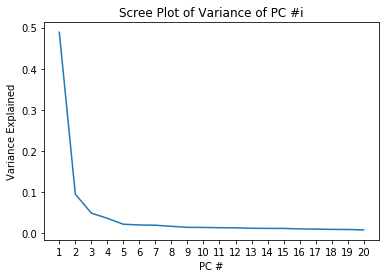

In [77]:
plt.plot(np.arange(1, 21), lst);
plt.xticks(np.arange(1, 21), np.arange(1, 21));
plt.xlabel('PC #');
plt.ylabel('Variance Explained');
plt.title('Scree Plot of Variance of PC #i')

In [80]:
def plot_pc(col_names, vt, k):
    plt.bar(col_names, vt[k, :], alpha=0.7)
    plt.xticks(col_names, rotation=90);

Text(0.5, 1.0, 'Values of the 1st Principal Component Direction')

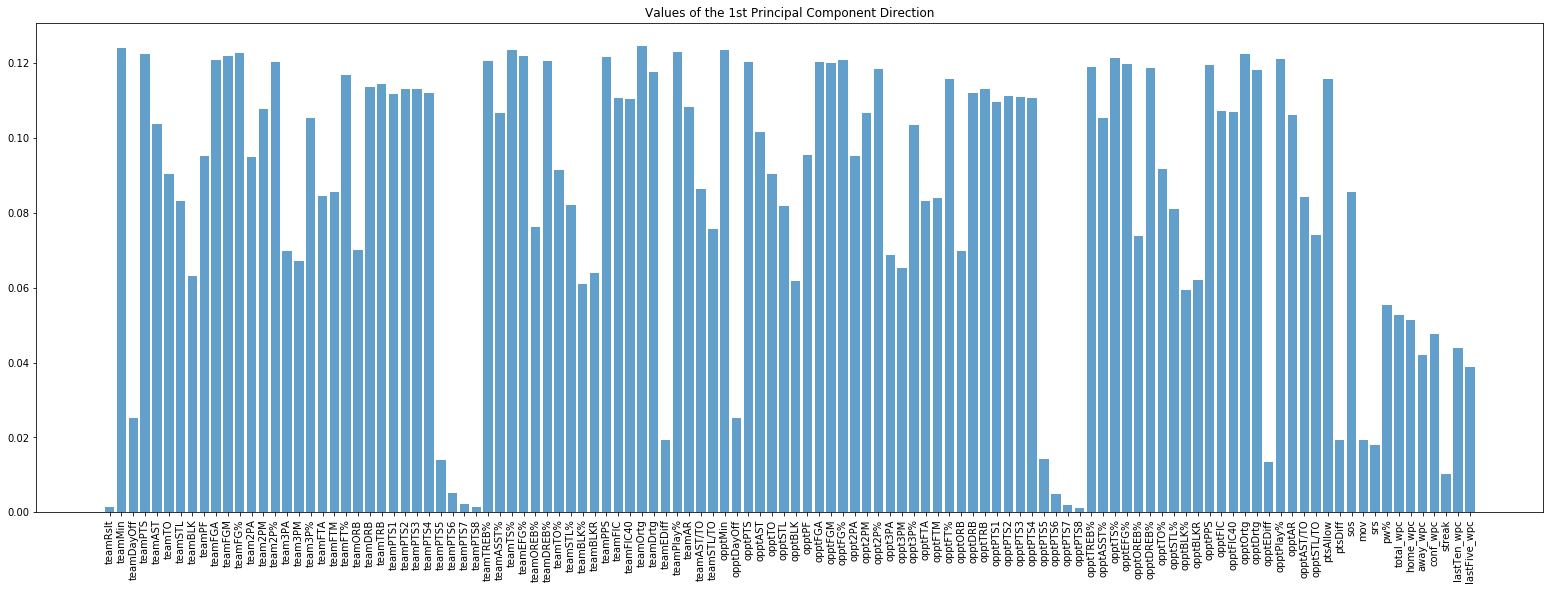

In [94]:
tbs_col_names = tbs_numbers.columns

with plt.rc_context({"figure.figsize": (27, 9)}):
    plot_pc(tbs_col_names, vt, 0);
plt.title('Values of the 1st Principal Component Direction')

In [101]:
pc_matrix.shape

(14702, 116)

### ii. Investigating Correlation

## MUST USE ORIGINAL DATA FOR THIS, HAVING AVERAGES MESSES IT UP

In [305]:
columns_of_interest = ['teamFGA', 'teamORB', 'teamSTL', 'teamOrtg', 'teamTO%', 'teamDrtg', 'teamDRB', 'teamBLKR']

Text(0.5, 1, 'Correlation between Various NBA Statistics')

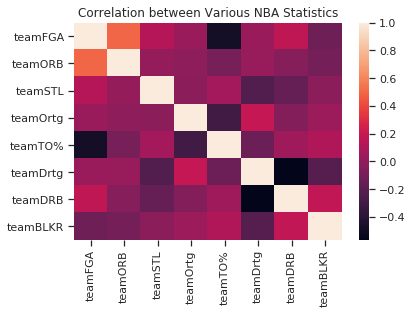

In [306]:
team_box_score_simple = team_box_score[columns_of_interest]
sns.heatmap(team_box_score_simple.corr())
plt.title('Correlation between Various NBA Statistics')

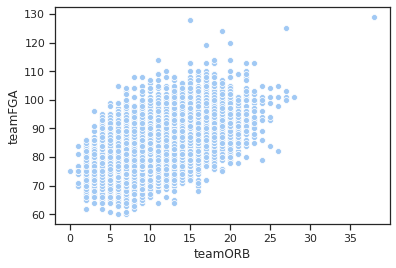

In [312]:
sns.scatterplot(x='teamORB', y='teamFGA', data=team_box_score_simple)

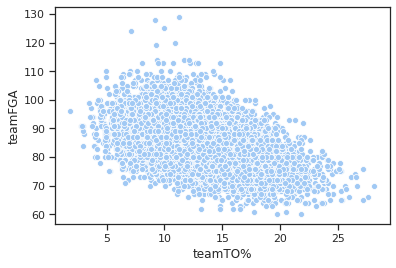

In [311]:
sns.scatterplot(x='teamTO%', y='teamFGA', data=team_box_score_simple)

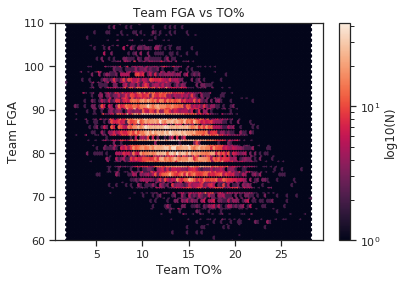

In [323]:
plt.hexbin(x=team_box_score_simple['teamTO%'], y=team_box_score_simple['teamFGA'], bins='log')
plt.ylim(60, 110)
plt.colorbar().set_label('log10(N)')
plt.xlabel('Team TO%')
plt.ylabel('Team FGA')
plt.title('Team FGA vs TO%')
plt.show()

### iii. Analyzing Categorical Data

In [324]:
df = get_nth_season(team_box_score, 2)
home_games = df[df['teamLoc'] == 'Home'].groupby('gmDate').mean()
away_games = df[df['teamLoc'] == 'Away'].groupby('gmDate').mean()

home_games['teamRslt'] = home_games.teamRslt.expanding().mean()
away_games['teamRslt'] = away_games.teamRslt.expanding().mean()

# join em back together
home_games = home_games.assign(teamLoc='Home')
away_games = away_games.assign(teamLoc='Away')

df = pd.concat([home_games, away_games])
df = df.sort_values(by='gmDate')
df = df.reset_index()

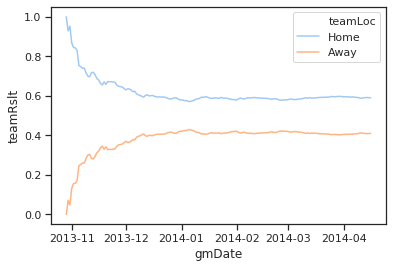

In [325]:
sns.lineplot(x="gmDate", y="teamRslt", hue="teamLoc", data=df)

## VII: Inference and Prediction

This is where we will build a model. Make sure to have training, val (so we can say we did cross validation), and test data. We have 6 seasons total; we can make 4 of them and the first 30 games of the 5th season training data, remainder of the 5th season val data, and the 6th season test data (or something, may be better to not make beginning of season data test as we'll prolly fail a lot of initial games just because all stats would be 0).